In [42]:
# imports
import pandas as pd
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from scipy.optimize import least_squares
from datetime import date, timedelta
import os


In [43]:
Psi = pd.read_csv('../../dados_usados/psi.csv')

dados = pd.read_csv("../../dados_usados/dados").values

dados_datas = dados[:,1]
dados_casos = dados[:,2]
dados_mortes = dados[:,3]
dados_hospitalizados = dados[:,4]
dados_hospitalizados_vacinados = dados[:,5]
dados_infectados_vacinados = dados[:,6]
dados_vacinados_acumulados = dados[:,7]

In [44]:
# Facendo média móvel do PSI
copy = Psi.copy()
Psi = np.append(Psi, copy)
Psi = Psi

npd = len(Psi)
Nfo = 8

Psif = [[0]]*npd

for k in range(1, npd):
    if (k-Nfo) < 0 :
        Psif[k] = 1/k*sum(Psi[0:k])
    else:
        Psif[k] = 1/Nfo*sum(Psi[k-Nfo:k])

Psif.pop(0)

[0]

In [45]:
# Limpando dados de vacinados
vacinados_dados_aux =  np.copy(np.diff(dados_vacinados_acumulados))
# Diffs menores que 0 serão substituidos pela repetição do valor anterior, tornando todo valor igual ou maior que o anterior
for i in range(1,len(vacinados_dados_aux)):
    diff = vacinados_dados_aux[i] - vacinados_dados_aux[i-1]
    if diff < 0:
        vacinados_dados_aux[i-1] = vacinados_dados_aux[i]

novos_vacinados =  np.diff(vacinados_dados_aux)
novos_vacinados = novos_vacinados.tolist()
novos_vacinados.insert(0, 0)

In [46]:
# Ultima revisão: 05/01/2023
k = 1/4
gamma_a = 1/3.5
gamma_s = 1/4
gamma_h = 0.18
gamma_u = 0.13
mi_u = 0.4
qsi = 0.53 
h = 0.06
h_v = 0.012
mi_h = 0.15
ome_h = 0.14
ome_u = 0.29
delta = 0.31
p = 0.2

In [47]:
# def modelo 
def SEIIHURD(t, y, args):

    # t0, b0, t1, b1, t2, b2, t3, b3, t4, b4, t5, b5, b_else = args

    b0, b1, t0, t1 = args

    if t<20.178:
        beta=2.1317
    elif (t>=20.178-8) and (t < 72.94):
        beta=1.7645
    elif (t>=72.94) and (t < 148):
        beta=1.1281
    elif (t>=107.76354915) and (t < 149.34736536):
        beta=2.59807746
    elif(t >= 235.35360579 and t < t0):
        beta = 1.26315674
    elif (t >= t0 and t < t1):
        beta = b0
    elif (t >= t1):
        beta = b1
    else:
        beta=1

    beta_v = beta

    tau = novos_vacinados[int(t)]

    if t >= 321: # 321 é quando começa a vacina
        delta_av = 0.31
        delta_sv = 0.31
        phi_e = 0.7
        k_v=1/3
        p_v = 0.1
        gamma_av = 1/3.5
        gamma_sv = 1/4
        gamma_vu=0.26
        qsi_v = 0.99
        eps=0.7
        mi_vh=0.03
        mi_vu=0.08
        gamma_vh=0.36
    else:
        delta_av = 0
        delta_sv = 0
        phi_e = 0
        k_v=0
        p_v = 0
        gamma_av = 0
        gamma_sv = 0
        gamma_vu=0
        qsi_v = 0
        eps=0
        mi_vh=0
        mi_vu=0
        gamma_vh=0

    N=14873064
    
    psi = Psif[int(t)]
    S=y[0]
    E=y[1]
    V=y[2]
    Sv=y[3]
    Ev=y[4]
    Ia=y[5]
    Is=y[6]
    Iav=y[7]
    Isv=y[8]
    H=y[9]
    Hv=y[10]
    U=y[11]
    Uv=y[12]
    R=y[13]
    Rv=y[14]
    D=y[15]
    Nw=y[16]
    NwV=y[17]
    NHn=y[18]
    NHnV=y[19]
    NIav=y[20]

    dSdt = (-(1-psi)*beta*S*(Is+delta*Ia+delta_av*Iav+delta_sv*Isv)) - tau/N
    dEdt = ((1-psi)*beta*(Is+delta*Ia+delta_av*Iav+delta_sv*Isv)*(S+V)) - k*E
    dVdt = tau/N - phi_e*V - ((1-psi)*beta*V*(Is+delta*Ia+delta_av*Iav+delta_sv*Isv))
    dSvdt =  phi_e*(1-eps)*V - ((1-psi)*beta_v*Sv*(Is+delta*Ia+delta_av*Iav+delta_sv*Isv)) #- phi_e*eps*Sv
    dEvdt = ((1-psi)*beta_v*Sv*(Is+delta*Ia+delta_av*Iav+delta_sv*Isv)) - k_v*Ev
    dIadt = (1-p)*k*E - gamma_a*Ia
    dIsdt = p*k*E - gamma_s*Is
    dIavdt = (1-p_v)*k_v*Ev - gamma_av*Iav
    dIsvdt = p_v*k_v*Ev - gamma_sv*Isv
    dHdt = h*qsi*gamma_s*Is + (1-mi_u+ome_u*mi_u)*gamma_u*U - gamma_h*H   
    dHvdt = h_v*qsi_v*gamma_sv*Isv + (1-mi_vu+ome_u*mi_vu)*gamma_vu*Uv - gamma_vh*Hv    
    dUdt = h*(1-qsi)*gamma_s*Is + ome_h*gamma_h*H - gamma_u*U
    dUvdt = h_v*(1-qsi_v)*gamma_sv*Isv + ome_h*gamma_vh*Hv - gamma_u*Uv
    dRdt = gamma_a*Ia + (1-h)*gamma_s*Is + (1-mi_h)*(1-ome_h)*gamma_h*H
    dRvdt = gamma_av*Iav + (1-h_v)*gamma_sv*Isv + (1-mi_vh)*(1-ome_h)*(gamma_vh*Hv) + phi_e*eps*V
    dDdt = (1-ome_h)*(mi_h*gamma_h*H +mi_vh*gamma_vh*Hv) + (1-ome_u)*(mi_u*gamma_u*U+mi_vu*gamma_vu*Uv)
    dNwdt = p*k*E 
    dNwVdt = tau/N
    dHndt = h*qsi*gamma_s*Is
    dHnvdt = h_v*qsi_v*gamma_sv*Isv 
    dNIAvdt = p_v*k_v*Ev

    return [dSdt, dEdt, dVdt, dSvdt, dEvdt, dIadt, dIsdt, dIavdt, dIsvdt, dHdt, dHvdt, dUdt, dUvdt, dRdt, 
            dRvdt, dDdt, dNwdt, dNwVdt, dHndt, dHnvdt, dNIAvdt]

In [48]:
# lq_SIR
def lq_SIR(pars, data, ts0, q0):

    b0, b1, t0, t1 = pars
    #parameters
    parode = b0, b1, t0, t1
    #calls integrator

    qs = solve_ivp(fun=SEIIHURD, t_span=[0, len(novos_vacinados)-2], args=(parode,) ,y0=q0, dense_output=True, method="RK45",  t_eval=np.arange(len(novos_vacinados)-2))
    qs = qs.y
    
    N=14873064

    mortos_modelo           = (qs[-6,:]*N).astype(float)
    casos_modelo            = (qs[-5,:]*N).astype(float)
    casos_vacinados_modelo  = (qs[-1,:]*N).astype(float)
    hosp_modelo             = (qs[-3,:]*N).astype(float)
    hospVac_modelo          = (qs[-2,:]*N).astype(float)

    novos_mortos            = (dados_mortes)[:611].astype(float)
    novos_casos             = (dados_casos)[:611].astype(float)
    novos_casos_vacinados   = (dados_infectados_vacinados)[:611].astype(float)
    novos_hosp              = (dados_hospitalizados)[:611].astype(float)
    novos_hosp_vac          = (dados_hospitalizados_vacinados)[:611].astype(float)
    
    # casos = np.diff(qs[:, -2]*14930634)
    #define the standardized residuals
    errMortos = (mortos_modelo - novos_mortos) / np.sqrt(mortos_modelo+1)
    errCasos = (casos_modelo - novos_casos)/np.sqrt(casos_modelo+1)
    errCasosVacinados = (casos_vacinados_modelo - novos_casos_vacinados)/np.sqrt(casos_vacinados_modelo+1)
    errHosp = (hosp_modelo - novos_hosp) / np.sqrt(hosp_modelo+1)
    errHospVac = (hospVac_modelo - novos_hosp_vac) / np.sqrt(hospVac_modelo+1)
    return np.r_[errMortos, errCasos, errCasosVacinados, errHosp, errHospVac]


In [53]:
# Condições iniciais

N=14873064

D0          = 0
N0          = 14930634
R0          = 0
H0          = 0
HV0         = 0
U0          = 0
UV0         = 0
V0          = 0
Rv0         = 0
Is0         = 2.015439771376298e-06
Ia0         = 1.8028646508967777e-06
Iav0        = 1.8028646508967777e-06 
Isv0        = 1.8028646508967777e-06 
E0          = 1.7639153732952095e-06
Ev0         = 1.7639153732952095e-06
S0          = (1-Is0-Ia0-E0)
Sv0         = 0 
Nw0         = 0
NwV0        = 0

condicoes_iniciais = [S0,E0,V0, Sv0, Ev0, Ia0, Is0, Iav0, Isv0, H0, HV0, U0, UV0, R0, Rv0, D0, Nw0, NwV0, 0, 0, 0]

In [50]:
# Best Fit
def Best_Fit(data,n_tries, ts0, q0):

    # #DEEFINE THE INTERVALS OF PARS[0, 2.],[0, 2.], [0, 5.], [0, 5.],[0, 5.],[0, 80], [80, 170], [170, 240], [240, 400]  310
    intervals = np.array([[0, 5.], [0, 5.], [235.35360580, 400], [401, 628]])
    #NUMBER OF FITS
    #best error starts at inft 
    best_err = np.inf
    #aj the number of best fists 
    aj = 0
    for i in range(n_tries):
        if i%5 == 0:
            print(i)
            
        #create a set of parameters in the interval
        par0 = np.random.rand(len(intervals))
        par0 = intervals[:,0] + par0 * (intervals[:,1] - intervals[:,0])

        try:
            res = least_squares(lambda pars: lq_SIR(pars,data, ts0, q0), par0, bounds=(intervals[:,0], \
                                            intervals[:,1]))

            ier = res.status
            #if converges
            if ier >= 1 and ier <= 4:
                if res.cost < best_err:
                    #best_err = erro
                    best_err = res.cost
                    #best_pop = parametro
                    best_pop = res.x
                    #+1 best fit
                    aj = aj +1

                    print('achou',aj)
        except Exception as exp:
            print(exp)
            pass
                #in does not converge, do nothing

    return best_pop

In [55]:
#Run the minimizer

n_tries=50  #Quanto maior mais certeza do resultado. Colocar em 100 para roda com mais certeza (Ou até maiws se for necessário)
ts0 =  np.arange(len(novos_vacinados)-1)


best_pop=Best_Fit(np.diff(dados_mortes), n_tries, ts0, condicoes_iniciais)
b0, b1, t0, t1 = best_pop
parode = [b0, b1, t0, t1]
# t0,t1 = 317.72001799, 435.15640895
# parode = [1.57052078,   2.85820568, 324.07517388, 434.0124978]


# TEMPO FOI OTIMIZADO TAMBÉM 

#parode = [  1.5864754 ,   3.5051942 , 317.72001799, 435.15640895]
# calls integrator
qs = solve_ivp(fun=SEIIHURD, t_span=[0, len(novos_vacinados)-1], args=(parode,) ,y0=condicoes_iniciais, dense_output=True, method="RK45",  t_eval=np.arange(len(novos_vacinados)-1))
qs = qs.y

0
achou 1
achou 2
5
10
15
achou 3
20


/tmp/ipykernel_29255/41790900.py:30: RuntimeWarning: invalid value encountered in sqrt
  errCasosVacinados = (casos_vacinados_modelo - novos_casos_vacinados)/np.sqrt(casos_vacinados_modelo+1)


25
30
35
40
45


10874046.560679803


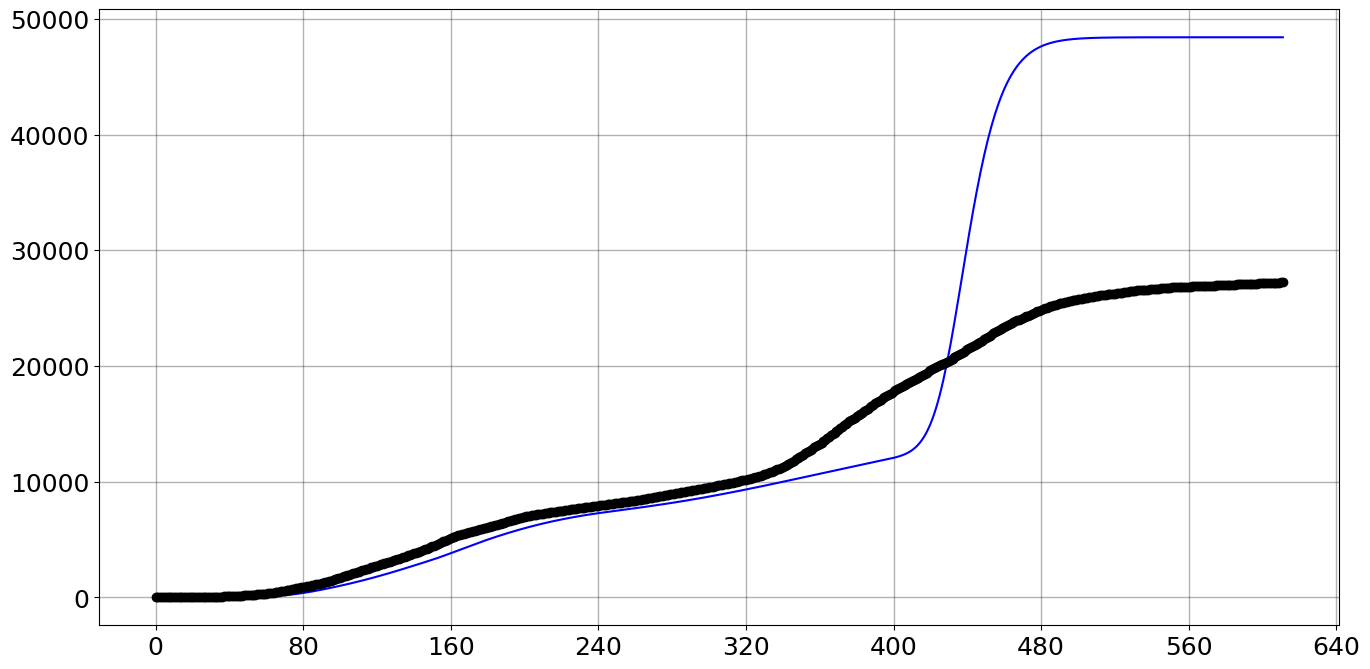

In [56]:
# plotando mortes
ts0 =  np.arange(len(novos_vacinados)-1)

qi = qs[-6,:] #mortes acumulados
errMortos = (qi - dados_mortes[:612]) / np.sqrt(qi+1)

    # mortos_modelo           = np.diff(qs[-6,:]*N)
    # casos_modelo            = np.diff(qs[-5,:]*N)
    # casos_vacinados_modelo   = np.diff(qs[-1,:]*N)
    # hosp_modelo             = np.diff(qs[-3,:]*N)
    # hospVac_modelo          = np.diff(qs[-2,:]*N)
#Criando plot
fig, ax = plt.subplots(figsize=(16,8))

#Desenhando grid no plot
ax.grid(which='major', axis='both', color='black',linewidth=1.,alpha=0.3)
ax.autoscale()

x_para_escala = np.arange(0, len(dados_datas)-2, 1)

ax.scatter(x_para_escala,  (dados_mortes)[:len(dados_datas)-2], color='black',zorder=3,label='Reported data')
#Plot the fitted function as a line.
ax.plot(x_para_escala, (N*qi)[:len(dados_datas)],color='blue',label='Fitted function')
#Set the labels
# ax.set_ylabel('Mortos',fontsize=22)
# ax.set_xlabel('Dias', fontsize=22)

#The size of the numbers on the axixis
ax.tick_params(labelsize=18)

#Limiting the ammount of dates on the X axixs
ax.xaxis.set_major_locator(plt.MaxNLocator(10))
#Rotating the dates for better visualization
# plt.setp(ax.get_xticklabels(), rotation=30)
print( np.cumsum(N*qi)[-1])

#Show Graph       
plt.show()

650299683.1789482


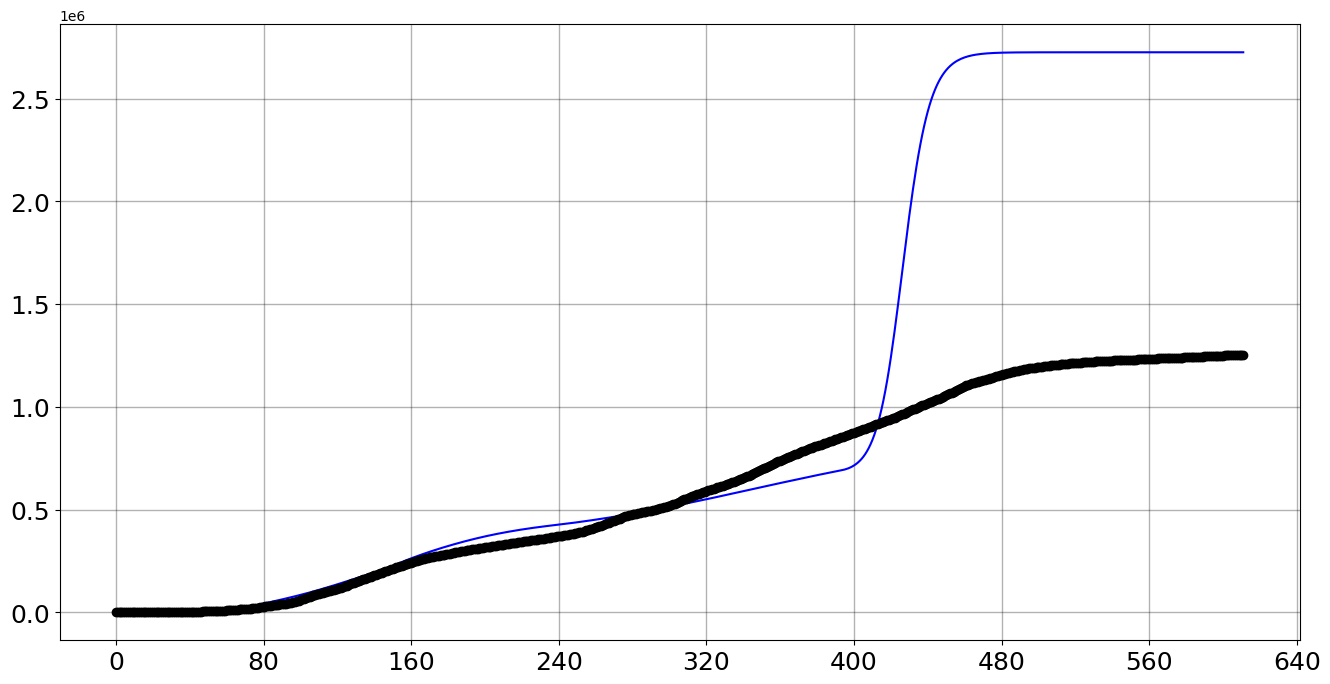

In [57]:
# plotando mortes
ts0 =  np.arange(len(novos_vacinados)-1)

qi = qs[-5,:] #mortes acumulados

    # mortos_modelo           = np.diff(qs[-6,:]*N)
    # casos_modelo            = np.diff(qs[-5,:]*N)
    # casos_vacinados_modelo   = np.diff(qs[-1,:]*N)
    # hosp_modelo             = np.diff(qs[-3,:]*N)
    # hospVac_modelo          = np.diff(qs[-2,:]*N)
#Criando plot
fig, ax = plt.subplots(figsize=(16,8))

#Desenhando grid no plot
ax.grid(which='major', axis='both', color='black',linewidth=1.,alpha=0.3)
ax.autoscale()

x_para_escala = np.arange(0, len(dados_datas)-2, 1)

ax.scatter(x_para_escala,  (dados_casos)[:len(dados_datas)-2], color='black',zorder=3,label='Reported data')
#Plot the fitted function as a line.
ax.plot(x_para_escala, (N*qi)[:len(dados_datas)],color='blue',label='Fitted function')
#Set the labels
# ax.set_ylabel('Mortos',fontsize=22)
# ax.set_xlabel('Dias', fontsize=22)

#The size of the numbers on the axixis
ax.tick_params(labelsize=18)

#Limiting the ammount of dates on the X axixs
ax.xaxis.set_major_locator(plt.MaxNLocator(10))
#Rotating the dates for better visualization
# plt.setp(ax.get_xticklabels(), rotation=30)
print( np.cumsum(N*qi)[-1])

#Show Graph       
plt.show()

248586.2013031692


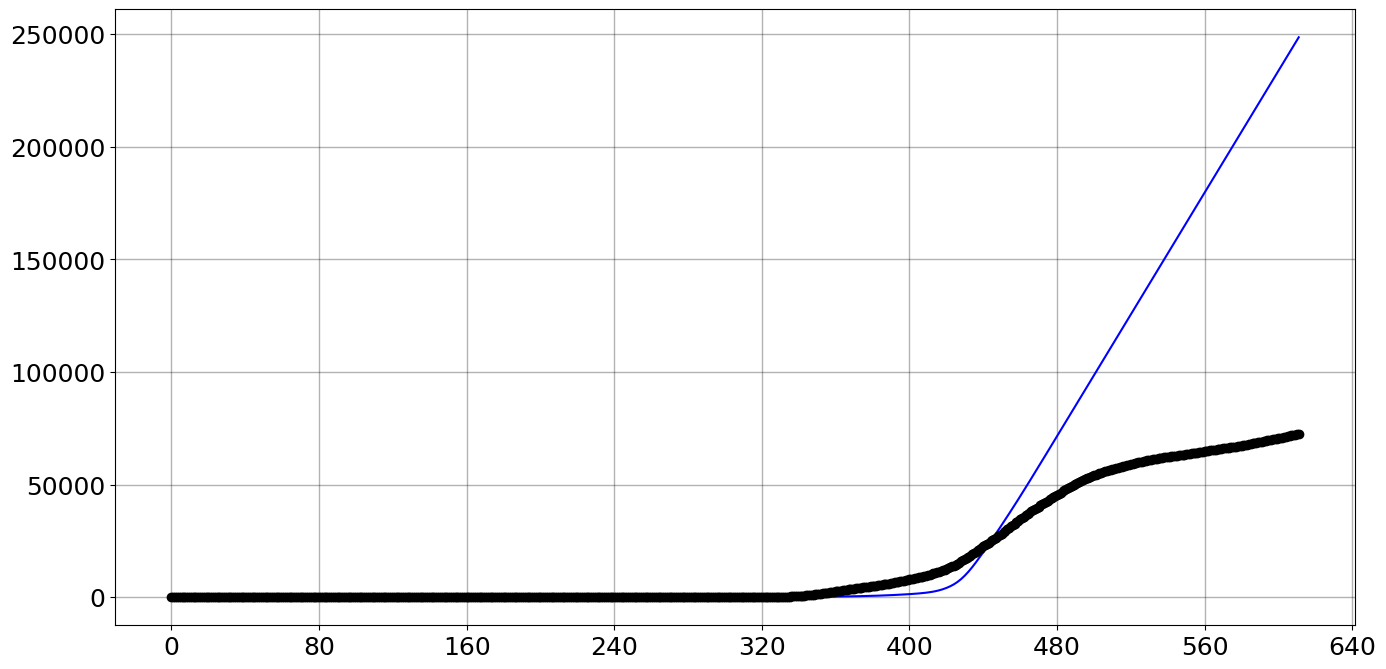

In [58]:
# plotando mortes
ts0 =  np.arange(len(novos_vacinados)-1)

qi = qs[-1,:] #mortes acumulados

    # mortos_modelo           = np.diff(qs[-6,:]*N)
    # casos_modelo            = np.diff(qs[-5,:]*N)
    # casos_vacinados_modelo   = np.diff(qs[-1,:]*N)
    # hosp_modelo             = np.diff(qs[-3,:]*N)
    # hospVac_modelo          = np.diff(qs[-2,:]*N)
#Criando plot
fig, ax = plt.subplots(figsize=(16,8))

#Desenhando grid no plot
ax.grid(which='major', axis='both', color='black',linewidth=1.,alpha=0.3)
ax.autoscale()

x_para_escala = np.arange(0, len(dados_datas)-2, 1)

ax.scatter(x_para_escala,  (dados_infectados_vacinados)[:len(dados_datas)-2], color='black',zorder=3,label='Reported data')
#Plot the fitted function as a line.
ax.plot(x_para_escala, np.cumsum(N*qi)[:len(dados_datas)],color='blue',label='Fitted function')
#Set the labels
# ax.set_ylabel('Mortos',fontsize=22)
# ax.set_xlabel('Dias', fontsize=22)

#The size of the numbers on the axixis
ax.tick_params(labelsize=18)

#Limiting the ammount of dates on the X axixs
ax.xaxis.set_major_locator(plt.MaxNLocator(10))
#Rotating the dates for better visualization
# plt.setp(ax.get_xticklabels(), rotation=30)
print( np.cumsum(N*qi)[-1])

#Show Graph       
plt.show()

20333422.049604315


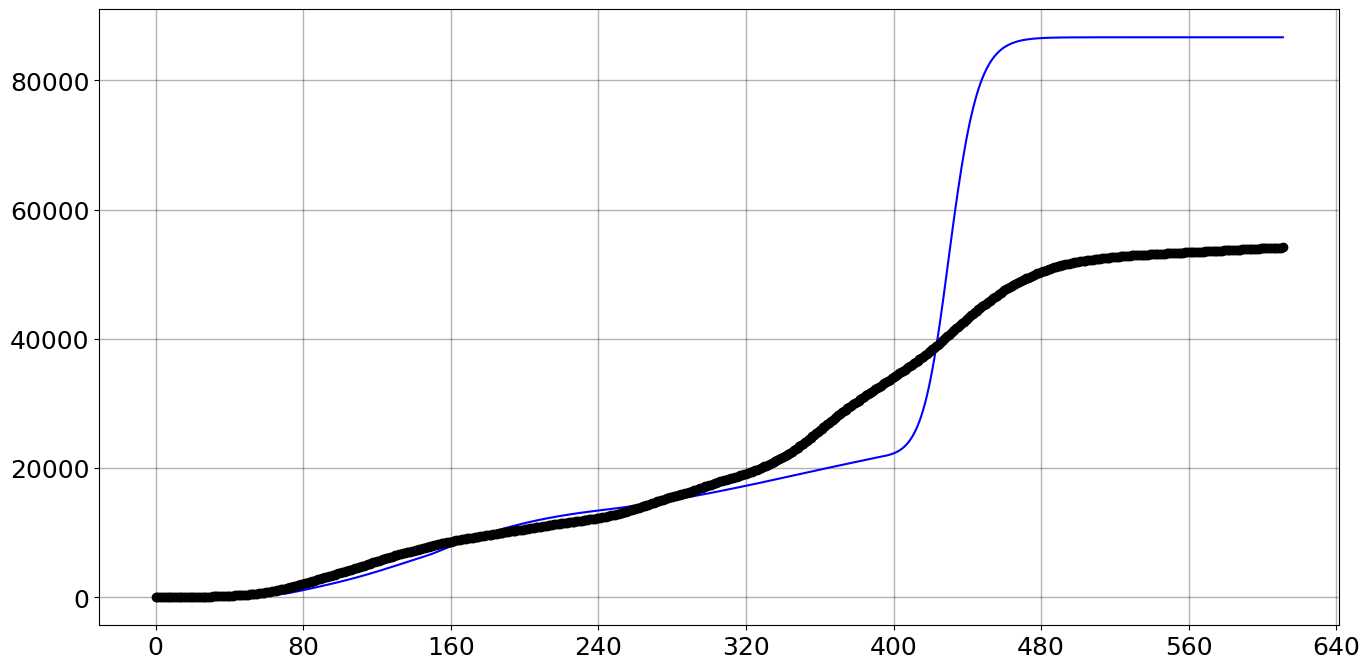

In [59]:
# plotando mortes
ts0 =  np.arange(len(novos_vacinados)-1)

qi = qs[-3,:] #mortes acumulados

    # mortos_modelo           = np.diff(qs[-6,:]*N)
    # casos_modelo            = np.diff(qs[-5,:]*N)
    # casos_vacinados_modelo   = np.diff(qs[-1,:]*N)
    # hosp_modelo             = np.diff(qs[-3,:]*N)
    # hospVac_modelo          = np.diff(qs[-2,:]*N)
#Criando plot
fig, ax = plt.subplots(figsize=(16,8))

#Desenhando grid no plot
ax.grid(which='major', axis='both', color='black',linewidth=1.,alpha=0.3)
ax.autoscale()

x_para_escala = np.arange(0, len(dados_datas)-2, 1)

ax.scatter(x_para_escala,  (dados_hospitalizados)[:len(dados_datas)-2], color='black',zorder=3,label='Reported data')
#Plot the fitted function as a line.
ax.plot(x_para_escala, (N*qi)[:len(dados_datas)],color='blue',label='Fitted function')
#Set the labels
# ax.set_ylabel('Mortos',fontsize=22)
# ax.set_xlabel('Dias', fontsize=22)

#The size of the numbers on the axixis
ax.tick_params(labelsize=18)

#Limiting the ammount of dates on the X axixs
ax.xaxis.set_major_locator(plt.MaxNLocator(10))
#Rotating the dates for better visualization
# plt.setp(ax.get_xticklabels(), rotation=30)
print( np.cumsum(N*qi)[-1])

#Show Graph       
plt.show()

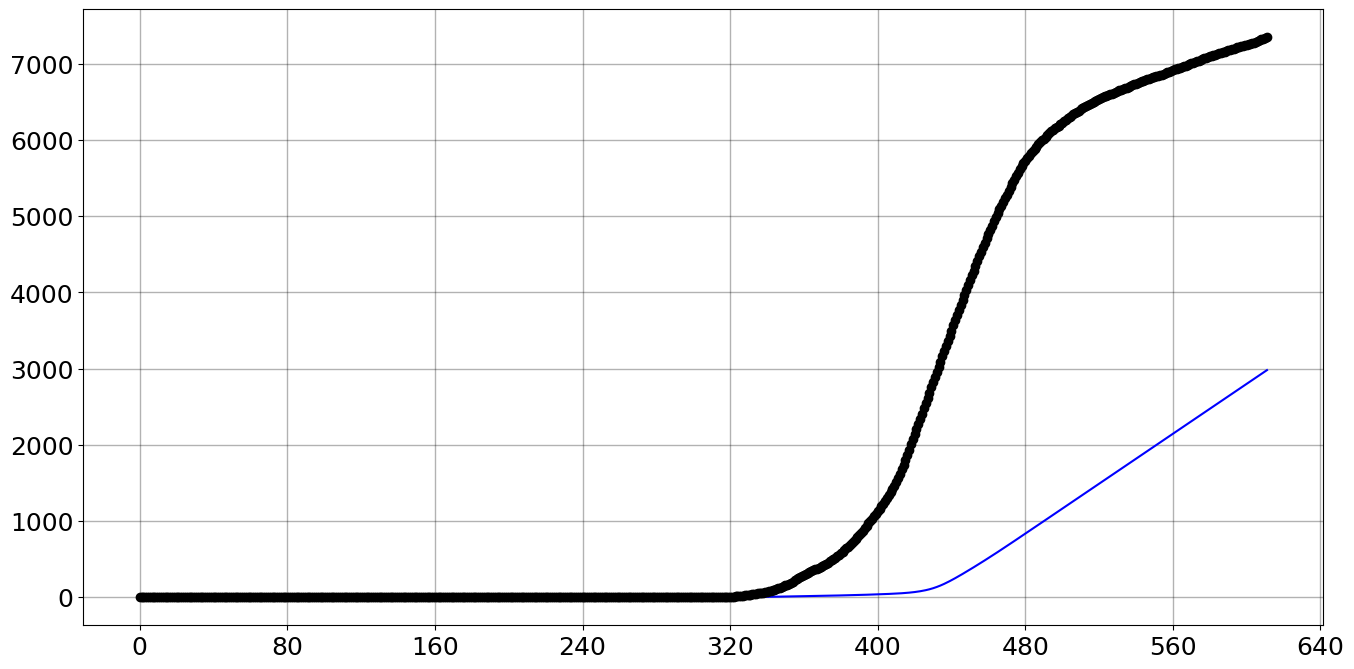

In [60]:
# plotando mortes
ts0 =  np.arange(len(novos_vacinados)-1)

qi = qs[-2,:] #mortes acumulados

    # mortos_modelo           = np.diff(qs[-6,:]*N)
    # casos_modelo            = np.diff(qs[-5,:]*N)
    # casos_vacinados_modelo   = np.diff(qs[-1,:]*N)
    # hosp_modelo             = np.diff(qs[-3,:]*N)
    # hospVac_modelo          = np.diff(qs[-2,:]*N)
#Criando plot
fig, ax = plt.subplots(figsize=(16,8))

#Desenhando grid no plot
ax.grid(which='major', axis='both', color='black',linewidth=1.,alpha=0.3)
ax.autoscale()

x_para_escala = np.arange(0, len(dados_datas)-2, 1)

ax.scatter(x_para_escala,  (dados_hospitalizados_vacinados)[:len(dados_datas)-2], color='black',zorder=3,label='Reported data')
#Plot the fitted function as a line.
ax.plot(x_para_escala, np.cumsum(N*qi)[:len(dados_datas)],color='blue',label='Fitted function')
#Set the labels
# ax.set_ylabel('Mortos',fontsize=22)
# ax.set_xlabel('Dias', fontsize=22)

#The size of the numbers on the axixis
ax.tick_params(labelsize=18)

#Limiting the ammount of dates on the X axixs
ax.xaxis.set_major_locator(plt.MaxNLocator(10))
#Rotating the dates for better visualization
# plt.setp(ax.get_xticklabels(), rotation=30)

#Show Graph       
plt.show()

In [ ]:
best_pop
#array([  1.5864754 ,   3.5051942 , 317.72001799, 435.15640895])

NameError: name 'best_pop' is not defined